In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import optuna
from time import time
from scipy.stats import randint, loguniform
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_squared_error as mse, r2_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor

In [ ]:
# dataset directory https://archive.ics.uci.edu/dataset/186/wine+quality

wine_src = '/content/winequality-red.csv'

In [ ]:
# upload as dataframe

wine_df = pd.read_csv(wine_src, delimiter=';')
display(wine_df)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6  

[1599 rows x 12 columns]

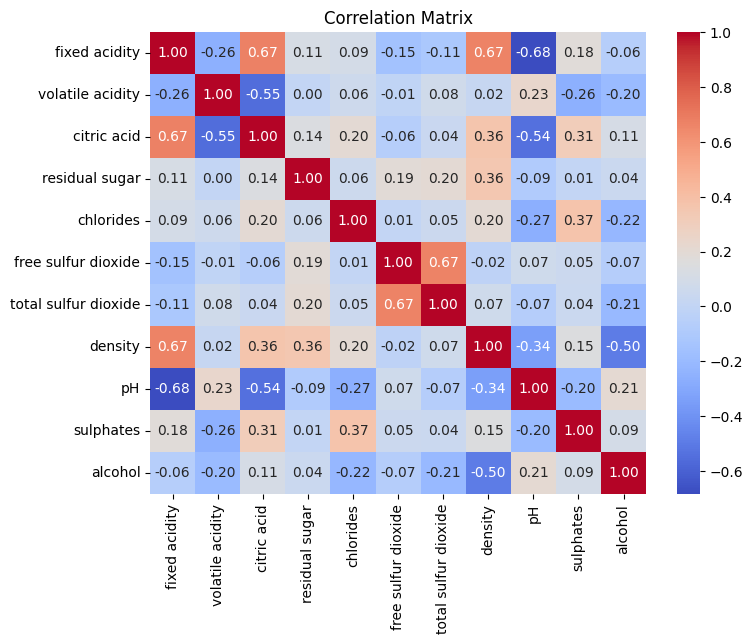

In [ ]:
# features correlation matrix

correlation_matrix = wine_df.drop('quality', axis=1).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

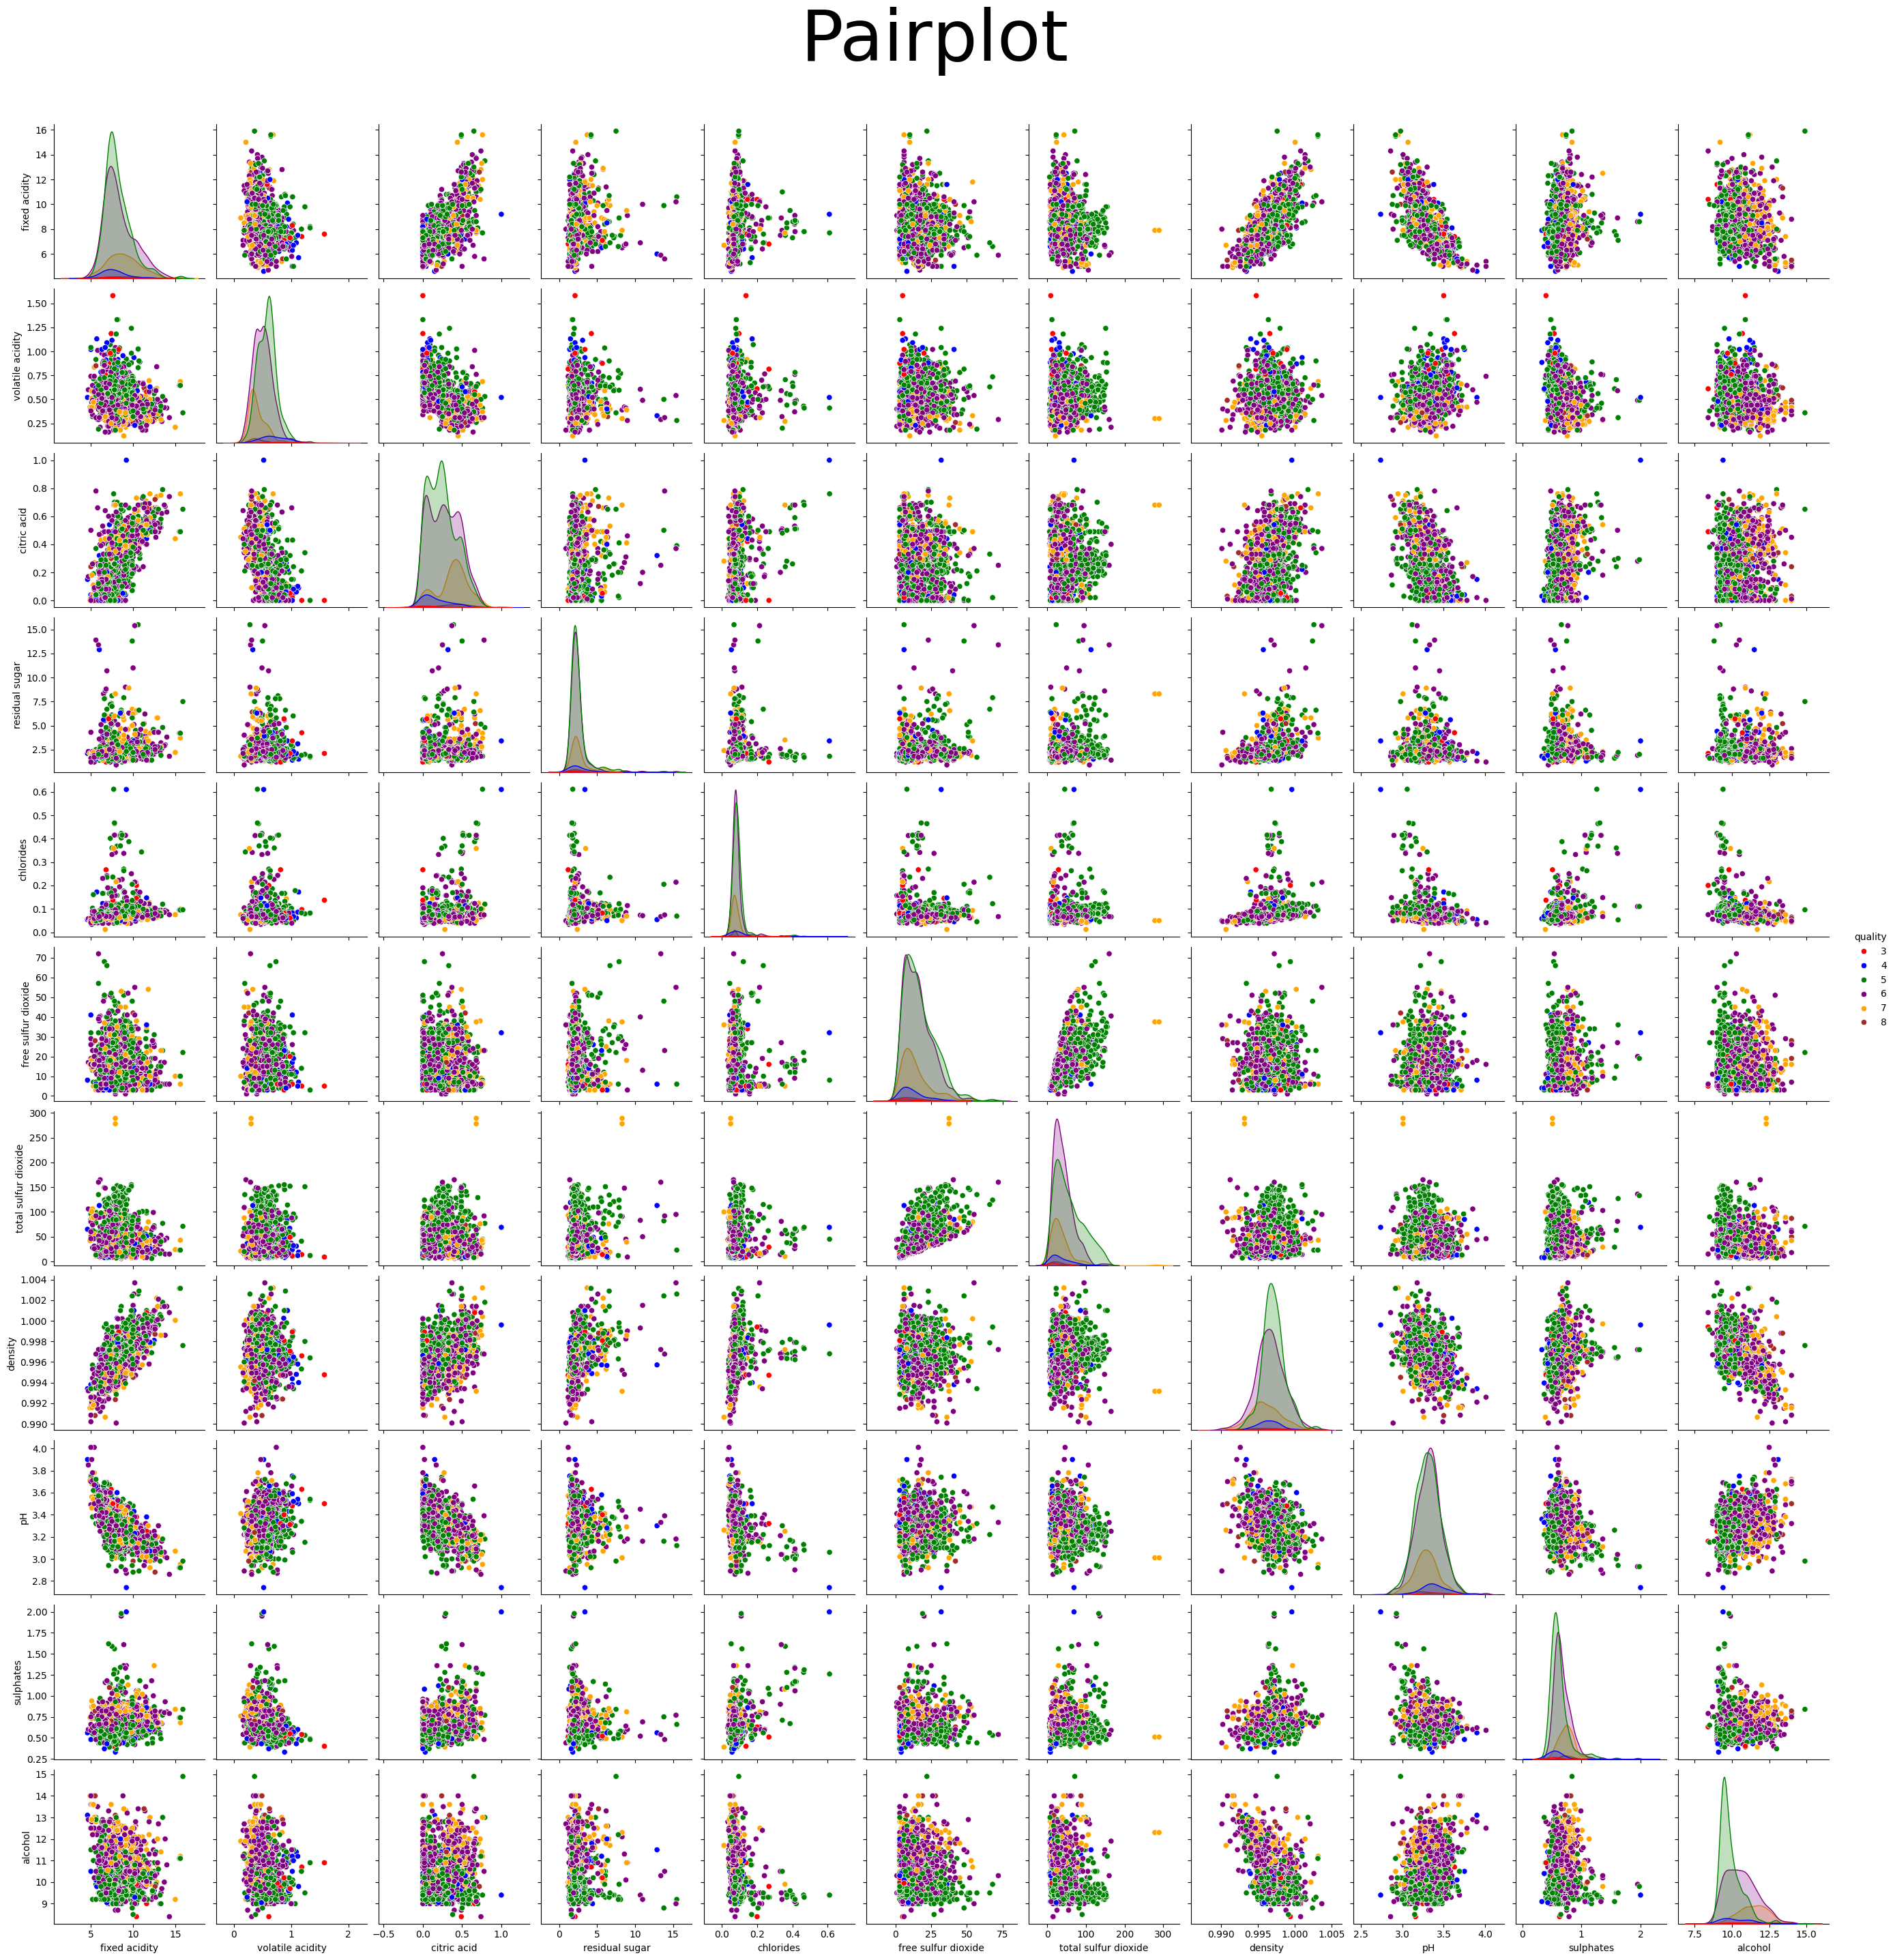

In [ ]:
# features pairplot

colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']
g = sns.pairplot(wine_df, hue='quality', palette=colors)
g.fig.suptitle('Pairplot', y=1.05, fontsize=75)
plt.show()

In [ ]:
# train-test split 70/30

x = wine_df.drop('quality', axis=1)
y = wine_df['quality']

X_test, X_train, y_test, y_train = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

# Problem 1. Wine Quality Dataset - Classification

## SVM

In [ ]:
def create_model(trial):
  kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

  if kernel == 'linear':
    C = trial.suggest_float('C', 0.001, 1000, log=True)
    model = OneVsRestClassifier(make_pipeline(StandardScaler(),
                                           SVC(kernel=kernel, C=C)))
  elif kernel == 'poly':
    C = trial.suggest_float('C', 0.01, 100, log=True)
    degree = trial.suggest_int('degree', 3, 10, step=1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    model = OneVsRestClassifier(make_pipeline(StandardScaler(),
                                           SVC(kernel=kernel, C=C, degree=degree, gamma=gamma)))
  elif kernel == 'rbf':
    C = trial.suggest_float('C', 0.001, 1000, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    model = OneVsRestClassifier(make_pipeline(StandardScaler(),
                                           SVC(kernel=kernel, C=C, gamma=gamma)))

  elif kernel == 'sigmoid':
    C = trial.suggest_float('C', 0.001, 1000, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    model = OneVsRestClassifier(make_pipeline(StandardScaler(),
                                           SVC(kernel=kernel, C=C, gamma=gamma)))

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return model

In [ ]:
def objective(trial):
  model = create_model(trial)
  scores = cross_val_score(model, X_train, y_train, cv=5)
  return np.mean(scores)

In [ ]:
start = time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)

best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train)

[I 2025-11-12 09:04:22,978] A new study created in memory with name: no-name-d3e586b9-80b1-4c22-be10-e5cd07c81a55
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[I 2025-11-12 09:04:23,295] Trial 0 finished with value: 0.5604166666666667 and parameters: {'kernel': 'linear', 'C': 0.1452867150813876}. Best is trial 0 with value: 0.5604166666666667.
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[I 2025-11-12 09:04:25,023] Trial 1 finished with value: 0.5604166666666667 and parameters: {'kernel': 'linear', 'C': 40.31607999201213}. Best is trial 0 with value: 0.5604166666666667.
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only



Best parameters:  {'kernel': 'rbf', 'C': 2.2917088287472525, 'gamma': 'scale'}


OneVsRestClassifier(estimator=Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(C=2.2917088287472525))]))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best cross-validation score: 0.61667
Performance on test data: 0.59696
Runtime: 43.2344 sec


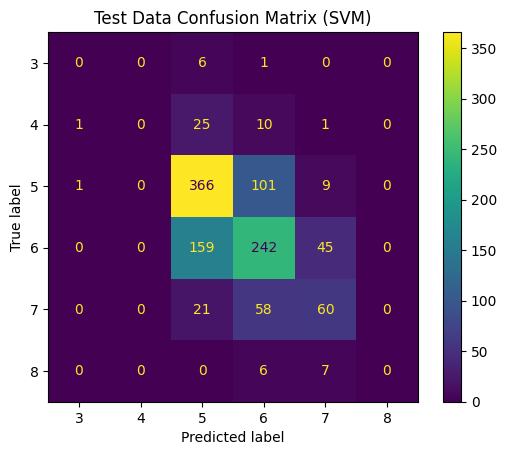

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        37
           5       0.63      0.77      0.69       477
           6       0.58      0.54      0.56       446
           7       0.49      0.43      0.46       139
           8       0.00      0.00      0.00        13

    accuracy                           0.60      1119
   macro avg       0.28      0.29      0.29      1119
weighted avg       0.56      0.60      0.58      1119



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
scores = cross_val_score(best_model, X_train, y_train, cv=5)
print("Best cross-validation score: %.5f" % np.mean(scores))
y_pred = best_model.predict(X_test)
print("Performance on test data: %.5f" % accuracy_score(y_test,y_pred))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

all_labels = np.sort(np.unique(y_test))

cfm = confusion_matrix(y_test, y_pred, labels=all_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (SVM)')
plt.show()

print(classification_report(y_test, y_pred))

## MLP

In [ ]:
model_params = {'mlpclassifier__alpha': loguniform(1e-4, 10),
                'mlpclassifier__solver': ['lbfgs','sgd','adam'],
                'mlpclassifier__hidden_layer_sizes': randint(4,16),
                'mlpclassifier__activation': ['identity','logistic','tanh','relu']}

pipeline = make_pipeline(StandardScaler(), MLPClassifier(max_iter=5000))

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

n_iter = 50
random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15] END mlpclassifier__activation=tanh, mlpclassifier__alpha=3.0011838356634786, mlpclassifier__hidden_layer_sizes=7, mlpclassifier__solver=sgd;, score=0.646 total time=   0.8s
[CV 2/15] END mlpclassifier__activation=tanh, mlpclassifier__alpha=3.0011838356634786, mlpclassifier__hidden_layer_sizes=7, mlpclassifier__solver=sgd;, score=0.615 total time=   0.8s
[CV 3/15] END mlpclassifier__activation=tanh, mlpclassifier__alpha=3.0011838356634786, mlpclassifier__hidden_layer_sizes=7, mlpclassifier__solver=sgd;, score=0.510 total time=   0.8s
[CV 4/15] END mlpclassifier__activation=tanh, mlpclassifier__alpha=3.0011838356634786, mlpclassifier__hidden_layer_sizes=7, mlpclassifier__solver=sgd;, score=0.552 total time=   0.8s
[CV 5/15] END mlpclassifier__activation=tanh, mlpclassifier__alpha=3.0011838356634786, mlpclassifier__hidden_layer_sizes=7, mlpclassifier__solver=sgd;, score=0.552 total time=   0.8s
[CV 6/15] END mlpclass

Performance on test data: 0.58981
Runtime: 680.5518 sec


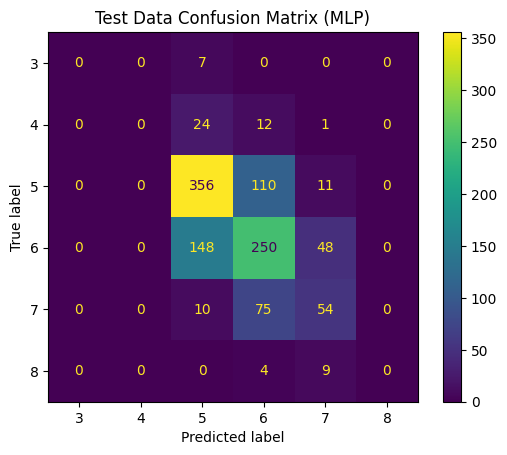

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        37
           5       0.65      0.75      0.70       477
           6       0.55      0.56      0.56       446
           7       0.44      0.39      0.41       139
           8       0.00      0.00      0.00        13

    accuracy                           0.59      1119
   macro avg       0.27      0.28      0.28      1119
weighted avg       0.55      0.59      0.57      1119



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
random_predictions = random_search.predict(X_test)
print("Performance on test data: %.5f" % accuracy_score(y_test, random_predictions))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

all_labels = np.sort(np.unique(y_test))

cfm = confusion_matrix(y_test, random_predictions, labels=all_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (MLP)')
plt.show()

print(classification_report(y_test, random_predictions))

## Random Forest

In [ ]:
model_params = {'criterion': ['gini','logloss','entropy'],
                'max_depth':[1,2,3,4,5],
                'n_estimators':[50,100,200]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

n_iter = 50
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=0), cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))


print(random_search.best_params_)
print(random_search.best_estimator_)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 45 is smaller than n_iter=50. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 15 folds for each of 45 candidates, totalling 675 fits
[CV 1/15] END criterion=gini, max_depth=1, n_estimators=50;, score=0.594 total time=   0.1s
[CV 2/15] END criterion=gini, max_depth=1, n_estimators=50;, score=0.615 total time=   0.1s
[CV 3/15] END criterion=gini, max_depth=1, n_estimators=50;, score=0.531 total time=   0.1s
[CV 4/15] END criterion=gini, max_depth=1, n_estimators=50;, score=0.500 total time=   0.1s
[CV 5/15] END criterion=gini, max_depth=1, n_estimators=50;, score=0.552 total time=   0.1s
[CV 6/15] END criterion=gini, max_depth=1, n_estimators=50;, score=0.562 total time=   0.1s
[CV 7/15] END criterion=gini, max_depth=1, n_estimators=50;, score=0.615 total time=   0.1s
[CV 8/15] END criterion=gini, max_depth=1, n_estimators=50;, score=0.531 total time=   0.1s
[CV 9/15] END criterion=gini, max_depth=1, n_estimators=50;, score=0.583 total time=   0.1s
[CV 10/15] END criterion=gini, max_depth=1, n_estimators=50;, score=0.583 total time=   0.1s
[CV 11/15] END c

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
225 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/util

Performance on test data: 0.60858
Runtime: 105.2955 sec


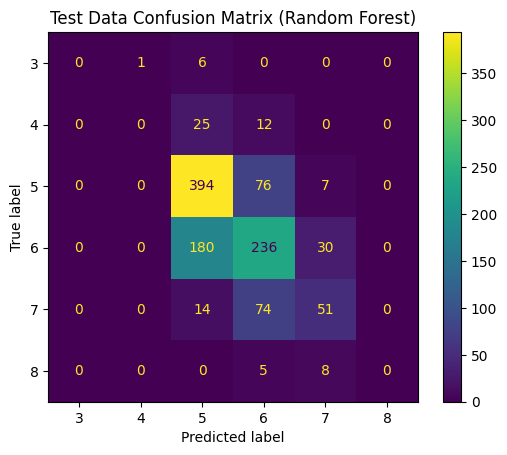

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        37
           5       0.64      0.83      0.72       477
           6       0.59      0.53      0.56       446
           7       0.53      0.37      0.43       139
           8       0.00      0.00      0.00        13

    accuracy                           0.61      1119
   macro avg       0.29      0.29      0.28      1119
weighted avg       0.57      0.61      0.58      1119



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
random_predictions = random_search.predict(X_test)
print("Performance on test data: %.5f" % accuracy_score(y_test, random_predictions))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

all_labels = np.sort(np.unique(y_test))

cfm = confusion_matrix(y_test, random_predictions, labels=all_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (Random Forest)')
plt.show()

print(classification_report(y_test, random_predictions))

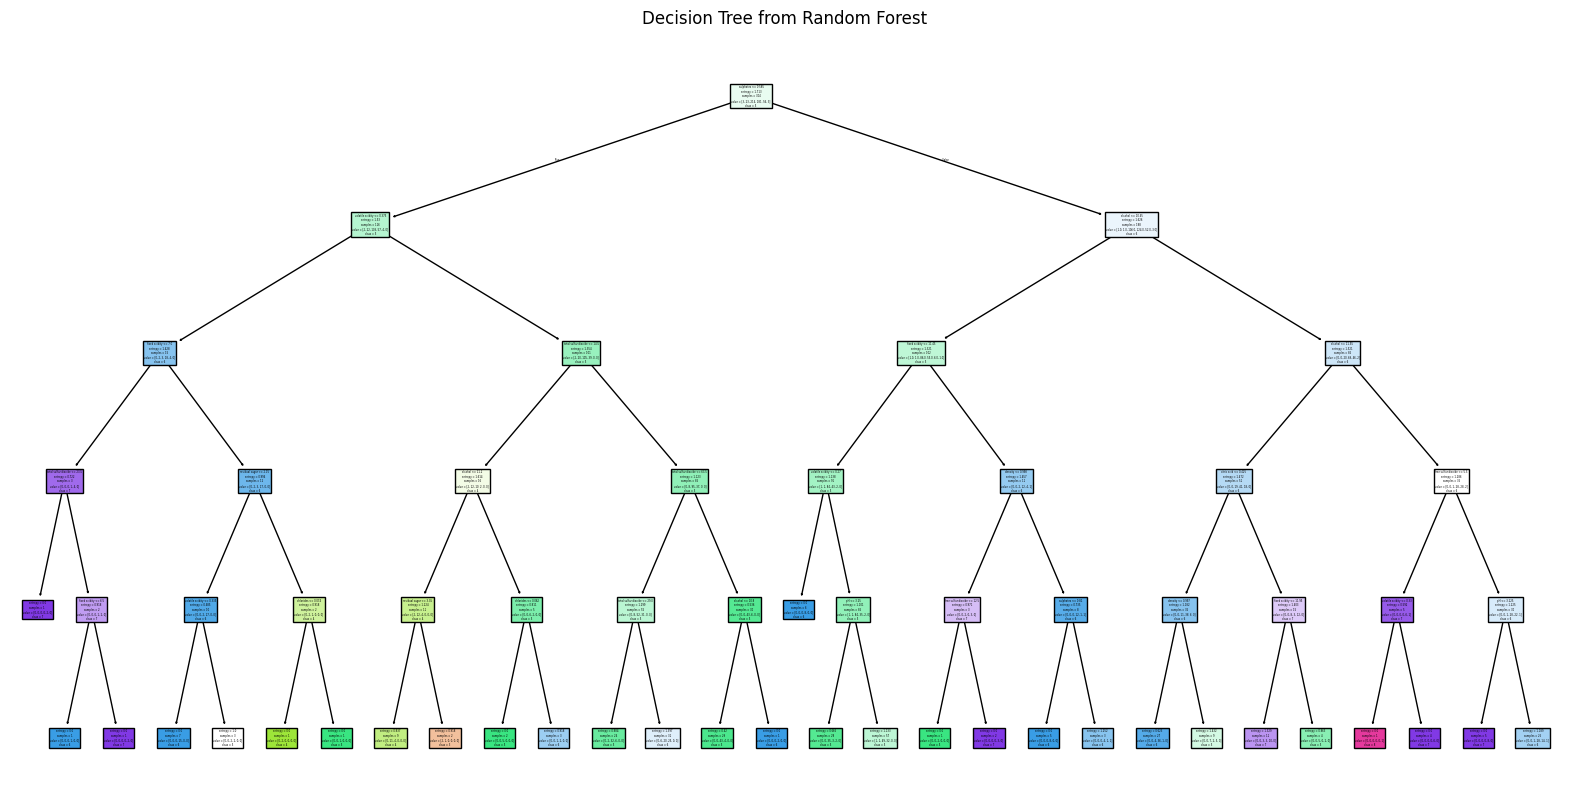

In [ ]:
one_tree = random_search.best_estimator_.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(one_tree, filled=True, feature_names=X_train.columns.tolist(), class_names=[str(c) for c in random_search.classes_])
plt.title("Decision Tree from Random Forest")
plt.show()

## Gradient Boost

In [ ]:
model_params = {'loss': ['log_loss'],
                'criterion':['friedman_mse', 'squared_error'],
                'learning_rate':[0.1,0.01,0.001],
                'n_estimators':[50,100,200]}

encoder = OrdinalEncoder()

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_encoded = encoder.fit_transform(y_train_reshaped)
y_test_encoded = encoder.transform(y_test_reshaped)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

n_iter = 50
random_search = RandomizedSearchCV(GradientBoostingClassifier(loss='log_loss', random_state=0), cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train_encoded)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

Fitting 15 folds for each of 18 candidates, totalling 270 fits
[CV 1/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.604 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.604 total time=   2.1s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.656 total time=   2.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.604 total time=   3.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.573 total time=   1.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.594 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.615 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.542 total time=   1.2s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.625 total time=   1.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.677 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.625 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.625 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.531 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.615 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.615 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.604 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.573 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.656 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.615 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.583 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.635 total time=   2.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.562 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.583 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.656 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.604 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.615 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.500 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.583 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.646 total time=   1.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.531 total time=   3.2s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.573 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.646 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.604 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.562 total time=   3.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.615 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.604 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.573 total time=   2.5s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.573 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.615 total time=   3.1s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.573 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.615 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.500 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.625 total time=   3.5s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.625 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.521 total time=   0.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.583 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.635 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.552 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.594 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.552 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.583 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.510 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.542 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.583 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.562 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.583 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.521 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.594 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.615 total time=   0.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.500 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.604 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.625 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.573 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.594 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.615 total time=   1.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.510 total time=   1.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.615 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.594 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.615 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.490 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.604 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.646 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.542 total time=   3.5s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.594 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.646 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.552 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.552 total time=   3.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.635 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.604 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.521 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.583 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.594 total time=   3.2s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.625 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.635 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.510 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.604 total time=   3.5s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.615 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.531 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.531 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.521 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.562 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.458 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.469 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.458 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.500 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.521 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.458 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.469 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.531 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.448 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.552 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.510 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.531 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.594 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.604 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.562 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.521 total time=   1.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.562 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.490 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.552 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.500 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.573 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.583 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.573 total time=   3.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.604 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.604 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.542 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.562 total time=   4.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.552 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.542 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.510 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.583 total time=   3.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.552 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.573 total time=   3.2s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.594 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.542 total time=   3.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.573 total time=   3.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=friedman_mse, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.583 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.594 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.604 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.656 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.583 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.583 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.594 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.635 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.542 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.625 total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.677 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.625 total time=   1.1s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.615 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.531 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.615 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=50;, score=0.615 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.594 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.573 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.656 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.635 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.573 total time=   1.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.646 total time=   1.8s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.562 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.583 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.656 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.604 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.615 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.500 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.583 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=100;, score=0.646 total time=   1.8s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.531 total time=   3.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.573 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.646 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.562 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.562 total time=   3.5s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.615 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.604 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.573 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.573 total time=   3.2s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.615 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.573 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.615 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.500 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.625 total time=   3.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=squared_error, learning_rate=0.1, loss=log_loss, n_estimators=200;, score=0.625 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.521 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.583 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.635 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.552 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.594 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.552 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.583 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.510 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.542 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.583 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.562 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.583 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.521 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.594 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=50;, score=0.615 total time=   0.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.500 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.604 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.625 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.531 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.573 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.594 total time=   1.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.615 total time=   2.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.510 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.615 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.594 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.615 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.500 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.604 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=100;, score=0.646 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.552 total time=   3.2s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.594 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.646 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.552 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.552 total time=   3.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.635 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.604 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.521 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.583 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.594 total time=   3.2s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.625 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.635 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.510 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.604 total time=   3.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=squared_error, learning_rate=0.01, loss=log_loss, n_estimators=200;, score=0.615 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.531 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.531 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.521 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.562 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.458 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.469 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.458 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.500 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.521 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.458 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.469 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.531 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.448 total time=   0.8s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.552 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=50;, score=0.510 total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.531 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.594 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.604 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.562 total time=   2.0s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.542 total time=   2.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.521 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.562 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.542 total time=   1.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.490 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.552 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.500 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.573 total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=100;, score=0.583 total time=   1.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.573 total time=   3.2s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.604 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.604 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.542 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.562 total time=   3.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.552 total time=   2.8s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.542 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.510 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.583 total time=   3.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.552 total time=   2.9s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.573 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.594 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.542 total time=   2.7s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.573 total time=   3.4s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/15] END criterion=squared_error, learning_rate=0.001, loss=log_loss, n_estimators=200;, score=0.583 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV took 466.91 seconds for 50 candidates parameter settings.
{'n_estimators': 50, 'loss': 'log_loss', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
GradientBoostingClassifier(n_estimators=50, random_state=0)


Performance on test data: 0.60679
Runtime: 565.6409 sec


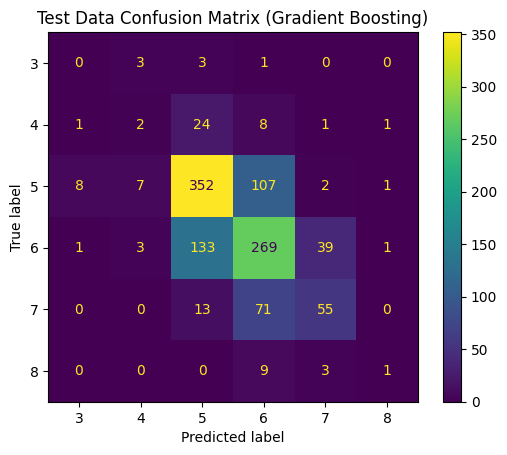

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.13      0.05      0.08        37
           5       0.67      0.74      0.70       477
           6       0.58      0.60      0.59       446
           7       0.55      0.40      0.46       139
           8       0.25      0.08      0.12        13

    accuracy                           0.61      1119
   macro avg       0.36      0.31      0.32      1119
weighted avg       0.59      0.61      0.60      1119



In [ ]:
random_predictions = random_search.predict(X_test)
print("Performance on test data: %.5f" % accuracy_score(y_test_encoded, random_predictions))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

y_test_original_labels = encoder.inverse_transform(y_test_encoded.reshape(-1, 1)).flatten()
random_predictions_original_labels = encoder.inverse_transform(random_predictions.reshape(-1, 1)).flatten()

all_original_labels = np.sort(np.unique(y_test_original_labels))

cfm = confusion_matrix(y_test_original_labels, random_predictions_original_labels, labels=all_original_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_original_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (Gradient Boosting)')
plt.show()

print(classification_report(y_test_original_labels, random_predictions_original_labels))

# Problem 2. Wine Quality Dataset - Regression

In [ ]:
def mean_absolute_deviation(y_test, y_pred):
  residuals = y_test - y_pred
  mean_residuals = np.mean(residuals)
  mad = np.mean(np.abs(residuals - mean_residuals))
  return mad

## SVM

In [ ]:
def create_model(trial):
  kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

  if kernel == 'linear':
    C = trial.suggest_float('C', 0.001, 1000, log=True)
    model = OneVsRestClassifier(make_pipeline(StandardScaler(),
                                           SVR(kernel=kernel, C=C)))
  elif kernel == 'poly':
    C = trial.suggest_float('C', 0.01, 100, log=True)
    degree = trial.suggest_int('degree', 3, 10, step=1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    model = OneVsRestClassifier(make_pipeline(StandardScaler(),
                                           SVR(kernel=kernel, C=C, degree=degree, gamma=gamma)))
  elif kernel == 'rbf':
    C = trial.suggest_float('C', 0.001, 1000, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    model = OneVsRestClassifier(make_pipeline(StandardScaler(),
                                           SVR(kernel=kernel, C=C, gamma=gamma)))

  elif kernel == 'sigmoid':
    C = trial.suggest_float('C', 0.001, 1000, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    model = OneVsRestClassifier(make_pipeline(StandardScaler(),
                                           SVR(kernel=kernel, C=C, gamma=gamma)))

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return model

In [ ]:
def objective(trial):
  model = create_model(trial)
  scores = cross_val_score(model, X_train, y_train, cv=5)
  return np.mean(scores)

In [ ]:
start = time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)

best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train)
scores = cross_val_score(best_model, X_train, y_train, cv=5)
print("Best cross-validation score: %.5f" % np.mean(scores))
y_pred = best_model.predict(X_test)
print("Performance on test data: %.5f" % accuracy_score(y_test,y_pred))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

[I 2025-11-12 09:18:10,359] A new study created in memory with name: no-name-d69b92ca-9388-4e6a-b1c3-52e656c07847
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[I 2025-11-12 09:18:10,798] Trial 0 finished with value: 0.5083333333333333 and parameters: {'kernel': 'linear', 'C': 0.003688218900073379}. Best is trial 0 with value: 0.5083333333333333.
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[I 2025-11-12 09:18:11,270] Trial 1 finished with value: 0.5041666666666667 and parameters: {'kernel': 'poly', 'C': 65.24660392480892, 'degree': 9, 'gamma': 'scale'}. Best is trial 0 with value: 0.5083333333333333.
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The leas



Best parameters:  {'kernel': 'rbf', 'C': 3.0481761450466927, 'gamma': 'auto'}
Best cross-validation score: 0.61667
Performance on test data: 0.59249
Runtime: 68.1815 sec


In [ ]:
print("Test Data MSE: %.5f" % mse(y_test, y_pred))
print("Test Data R2: %.5f" % r2_score(y_test, y_pred))
print("Test Data Mean Absolute Deviation: %.5f" % mean_absolute_deviation(y_test, y_pred))

Test Data MSE: 0.59875
Test Data R2: 0.08341
Test Data Mean Absolute Deviation: 0.48706


## MLP

In [ ]:
model_params = {'mlpregressor__solver': ['lbfgs','sgd','adam'],
                'mlpregressor__hidden_layer_sizes': randint(4,16),
                'mlpregressor__activation': ['identity','logistic','tanh','relu']}

pipeline = make_pipeline(StandardScaler(), MLPRegressor(max_iter=5000))

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

n_iter = 50
random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))


print(random_search.best_params_)
print(random_search.best_estimator_)

random_predictions = random_search.predict(X_test)

Fitting 15 folds for each of 50 candidates, totalling 750 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/15] END mlpregressor__activation=logistic, mlpregressor__hidden_layer_sizes=6, mlpregressor__solver=adam;, score=0.371 total time=   0.6s
[CV 2/15] END mlpregressor__activation=logistic, mlpregressor__hidden_layer_sizes=6, mlpregressor__solver=adam;, score=0.303 total time=   0.6s
[CV 3/15] END mlpregressor__activation=logistic, mlpregressor__hidden_layer_sizes=6, mlpregressor__solver=adam;, score=0.426 total time=   0.8s
[CV 4/15] END mlpregressor__activation=logistic, mlpregressor__hidden_layer_sizes=6, mlpregressor__solver=adam;, score=0.323 total time=   0.8s
[CV 5/15] END mlpregressor__activation=logistic, mlpregressor__hidden_layer_sizes=6, mlpregressor__solver=adam;, score=0.333 total time=   0.8s
[CV 6/15] END mlpregressor__activation=logistic, mlpregressor__hidden_layer_sizes=6, mlpregressor__solver=adam;, score=0.290 total time=   0.5s
[CV 7/15] END mlpregressor__activation=logistic, mlpregressor__hidden_layer_sizes=6, mlpregressor__solver=adam;, score=0.276 total time=

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-0.411 total time=   4.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-1.523 total time=   4.6s
[CV 3/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-0.432 total time=   4.1s
[CV 4/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-1.349 total time=   2.6s
[CV 5/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-0.352 total time=   2.4s
[CV 6/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-0.781 total time=   2.6s
[CV 7/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-1.503 total time=   2.6s
[CV 8/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-0.118 total time=   3.1s

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 13/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-1.160 total time=   5.1s
[CV 14/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-0.724 total time=   2.3s
[CV 15/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=15, mlpregressor__solver=lbfgs;, score=-0.613 total time=   1.7s
[CV 1/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.665 total time=   2.4s
[CV 2/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.404 total time=   5.3s
[CV 3/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.622 total time=   2.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.845 total time=   4.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-1.154 total time=   6.6s
[CV 6/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.480 total time=   2.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 7/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-2.352 total time=   4.4s
[CV 8/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.123 total time=   5.6s
[CV 9/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.560 total time=   1.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 10/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.402 total time=   4.4s
[CV 11/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.939 total time=   3.0s
[CV 12/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.861 total time=   4.2s
[CV 13/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.372 total time=   3.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 14/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.867 total time=   4.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 15/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=lbfgs;, score=-0.966 total time=   6.5s
[CV 1/15] END mlpregressor__activation=relu, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=sgd;, score=0.316 total time=   0.4s
[CV 2/15] END mlpregressor__activation=relu, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=sgd;, score=0.298 total time=   0.3s
[CV 3/15] END mlpregressor__activation=relu, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=sgd;, score=0.339 total time=   0.4s
[CV 4/15] END mlpregressor__activation=relu, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=sgd;, score=0.352 total time=   0.3s
[CV 5/15] END mlpregressor__activation=relu, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=sgd;, score=-0.115 total time=   0.3s
[CV 6/15] END mlpregressor__activation=relu, mlpregressor__hidden_layer_sizes=14, mlpregressor__solver=sgd;, score=-0.073 total time=   0.2s
[CV 7/15] END 

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 6/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=7, mlpregressor__solver=lbfgs;, score=-0.149 total time=   3.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 7/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=7, mlpregressor__solver=lbfgs;, score=-0.074 total time=   3.0s
[CV 8/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=7, mlpregressor__solver=lbfgs;, score=-6.840 total time=   0.7s
[CV 9/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=7, mlpregressor__solver=lbfgs;, score=-0.003 total time=   0.9s
[CV 10/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=7, mlpregressor__solver=lbfgs;, score=-0.063 total time=   1.8s
[CV 11/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=7, mlpregressor__solver=lbfgs;, score=-0.282 total time=   5.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 12/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=7, mlpregressor__solver=lbfgs;, score=-0.130 total time=   3.2s
[CV 13/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=7, mlpregressor__solver=lbfgs;, score=-0.201 total time=   1.3s
[CV 14/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=7, mlpregressor__solver=lbfgs;, score=-0.599 total time=   1.3s
[CV 15/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=7, mlpregressor__solver=lbfgs;, score=-5.050 total time=   0.7s
[CV 1/15] END mlpregressor__activation=logistic, mlpregressor__hidden_layer_sizes=12, mlpregressor__solver=adam;, score=0.393 total time=   0.5s
[CV 2/15] END mlpregressor__activation=logistic, mlpregressor__hidden_layer_sizes=12, mlpregressor__solver=adam;, score=0.293 total time=   0.4s
[CV 3/15] END mlpregressor__activation=logistic, mlpregressor__hidden_layer_sizes=12, mlpregressor__solver=adam;, score=0.432 total time= 

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 9/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=5, mlpregressor__solver=lbfgs;, score=0.123 total time=   2.7s
[CV 10/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=5, mlpregressor__solver=lbfgs;, score=-20.477 total time=   0.5s
[CV 11/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=5, mlpregressor__solver=lbfgs;, score=0.371 total time=   0.5s
[CV 12/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=5, mlpregressor__solver=lbfgs;, score=-0.544 total time=   1.2s
[CV 13/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=5, mlpregressor__solver=lbfgs;, score=0.035 total time=   0.8s
[CV 14/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=5, mlpregressor__solver=lbfgs;, score=0.251 total time=   0.4s
[CV 15/15] END mlpregressor__activation=tanh, mlpregressor__hidden_layer_sizes=5, mlpregressor__solver=lbfgs;, score=-0.115 total time=   0.7s
[CV

In [ ]:
print("Test Data MSE: %.5f" % mse(y_test, random_predictions))
print("Test Data R2: %.5f" % r2_score(y_test, random_predictions))
print("Test Data Mean Absolute Deviation: %.5f" % mean_absolute_deviation(y_test, random_predictions))

Test Data MSE: 0.44721
Test Data R2: 0.31539
Test Data Mean Absolute Deviation: 0.51668


## Random Forest

In [ ]:
model_params = {'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
                'max_depth':[1,2,3,4,5],
                'n_estimators':[50,100,200]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

n_iter = 50
random_search = RandomizedSearchCV(RandomForestRegressor(random_state=0), cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))


print(random_search.best_params_)
print(random_search.best_estimator_)

random_predictions = random_search.predict(X_test)

Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.263 total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[CV 2/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.200 total time=   0.2s
[CV 3/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.195 total time=   0.2s
[CV 4/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.091 total time=   0.2s
[CV 5/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.063 total time=   0.2s
[CV 6/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.219 total time=   0.2s
[CV 7/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.080 total time=   0.2s
[CV 8/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.242 total time=   0.2s
[CV 9/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.277 total time=   0.2s
[CV 10/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.036 total time=   0.2s
[CV 11/15] END criterion=absolute_error, max_depth=1, n_estimators=50;, score=0.0

In [ ]:
print("Test Data MSE: %.5f" % mse(y_test, random_predictions))
print("Test Data R2: %.5f" % r2_score(y_test, random_predictions))
print("Test Data Mean Absolute Deviation: %.5f" % mean_absolute_deviation(y_test, random_predictions))

Test Data MSE: 0.41404
Test Data R2: 0.36616
Test Data Mean Absolute Deviation: 0.50788


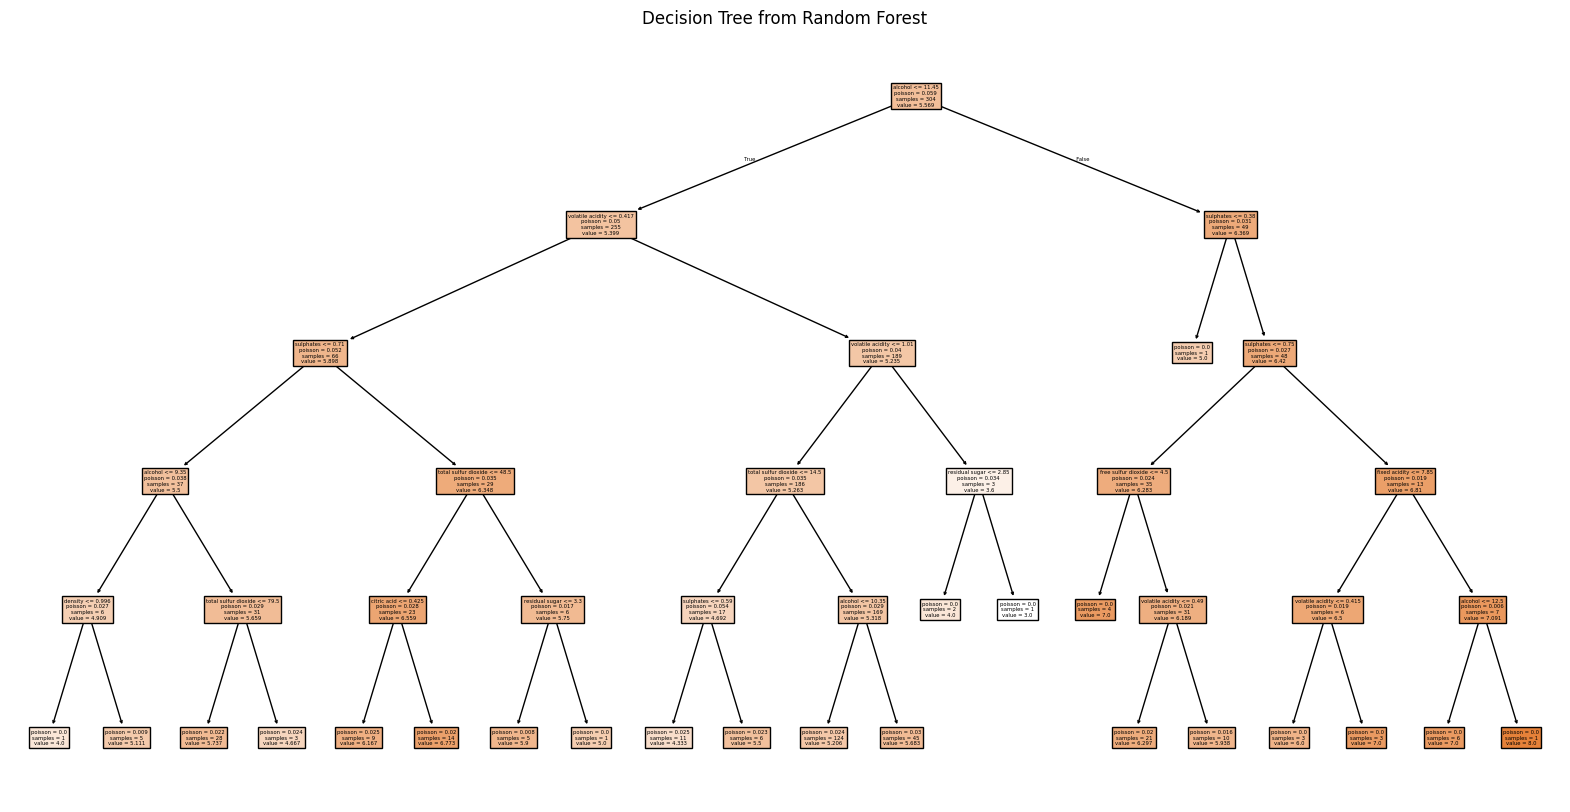

In [ ]:
one_tree = random_search.best_estimator_.estimators_[0]

# Plot the single tree
plt.figure(figsize=(20, 10))
plot_tree(one_tree, filled=True, feature_names=X_train.columns.tolist())
plt.title("Decision Tree from Random Forest")
plt.show()

## Gradient Boost

In [ ]:
model_params = {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion':['friedman_mse', 'squared_error'],
                'learning_rate':[0.1,0.01,0.001],
                'n_estimators':[50,100,200]}

encoder = OrdinalEncoder()

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_encoded = encoder.fit_transform(y_train_reshaped).ravel()
y_test_encoded = encoder.transform(y_test_reshaped).ravel()

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

n_iter = 50
random_search = RandomizedSearchCV(GradientBoostingRegressor(random_state=0), cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train_encoded)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))


print(random_search.best_params_)
print(random_search.best_estimator_)

random_predictions = random_search.predict(X_test)

Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15] END criterion=friedman_mse, learning_rate=0.001, loss=squared_error, n_estimators=100;, score=0.060 total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[CV 2/15] END criterion=friedman_mse, learning_rate=0.001, loss=squared_error, n_estimators=100;, score=0.070 total time=   0.2s
[CV 3/15] END criterion=friedman_mse, learning_rate=0.001, loss=squared_error, n_estimators=100;, score=0.048 total time=   0.2s
[CV 4/15] END criterion=friedman_mse, learning_rate=0.001, loss=squared_error, n_estimators=100;, score=0.062 total time=   0.2s
[CV 5/15] END criterion=friedman_mse, learning_rate=0.001, loss=squared_error, n_estimators=100;, score=0.074 total time=   0.2s
[CV 6/15] END criterion=friedman_mse, learning_rate=0.001, loss=squared_error, n_estimators=100;, score=0.047 total time=   0.2s
[CV 7/15] END criterion=friedman_mse, learning_rate=0.001, loss=squared_error, n_estimators=100;, score=0.064 total time=   0.2s
[CV 8/15] END criterion=friedman_mse, learning_rate=0.001, loss=squared_error, n_estimators=100;, score=0.067 total time=   0.3s
[CV 9/15] END criterion=friedman_mse, learning_rate=0.001, loss=squared_error, n_estimators=100;,

In [ ]:
print("Test Data MSE: %.5f" % mse(y_test, random_predictions))
print("Test Data R2: %.5f" % r2_score(y_test, random_predictions))
print("Test Data Mean Absolute Deviation: %.5f" % mean_absolute_deviation(y_test_encoded, random_predictions))

Test Data MSE: 9.46580
Test Data R2: -13.49071
Test Data Mean Absolute Deviation: 0.50519


# Results and Discussion

## Classification

Classification test accuracy among the different models used are not high but are comparable with each other, supported by the per-class metrics, which indicates that the models are roughly equally effective for classification for the dataset used.

1. SVM

* test accuracy: 0.59696

2. MLP

* test accuracy: 0.58981

3. RF

* test accuracy: 0.60858

4. GB

* test accuracy: 0.60679

## Regression

Regression metrics among the different models used are not only unpromising but also vary dramatically with each other, especially the MSE and R2 values. RF showed the lowest and best MSE result, and the highest and best R2 result, making RF the most effective model for this dataset. GB scored the worst in both MSE and R2.

1. SVM

* Test Data MSE: 0.59875
* Test Data R2: 0.08341
* Test Data Mean Absolute Deviation: 0.48706

2. MLP

* Test Data MSE: 0.44721
* Test Data R2: 0.31539
* Test Data Mean Absolute Deviation: 0.51668

3. RF

* Test Data MSE: 0.41404
* Test Data R2: 0.36616
* Test Data Mean Absolute Deviation: 0.50788

4. GB

* Test Data MSE: 9.46580
* Test Data R2: -13.49071
* Test Data Mean Absolute Deviation: 0.50519

The unimpressive performance of the models in both classification and regression problems is perhaps due to the extreme class imbalance that can be addressed with resampling techniques, and that there are too many input features that could be improved through dimensionality reduction.

In this case, given that the output classes of the dataset are ordinal integers, it is not recommended to treat it as a continuous variable for a regression problem and should remain as a discrete category, since classification models are consistent with the dataset and can reaffirm the results of one another.